# Finetuning UniMOF Model for WS24

This notebook demonstrates how to finetune a pretrained UniMOF model on the WS24 dataset. We'll utilize the pretrained weights and adapt the model for our specific task.

In [ ]:
#@title Install Uni-Core and dependencies
%%bash
cd /content

# install dependencies if not done already
if [ ! -f ENV_READY ]; then
    pip3 install rdkit
    pip3 install lmdb
    pip3 install pymatgen
    touch ENV_READY
fi

UNICORE_GIT='https://github.com/dptech-corp/Uni-Core.git'
WS24_UNIMOF_GIT='https://github.com/emd-aquila/Xc51-MOFs.git'

# install Uni-Core if not done already
if [ ! -f UNICORE_READY ]; then
    git clone -b main ${UNICORE_GIT}
    # fix error in code before installing
    perl -pi -e 's/state = torch\.load\(f, map_location=torch\.device\("cpu"\)\)/state = torch.load(f, map_location=torch.device("cpu"), weights_only=False)/' ./Uni-Core/unicore/checkpoint_utils.py
    pip3 install -e ./Uni-Core
    git clone -b main ${WS24_UNIMOF_GIT}
    touch UNICORE_READY
fi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.0/809.0 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 55.2 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=d336

Cloning into 'Uni-Core'...


In [ ]:
#@title Navigate to WS24 file
%cd /content/Xc51-MOFs/WS24-Uni-MOF

/content/drive/.shortcut-targets-by-id/1kUihxpYx3LIQGGuYc-LL6XEGfo17of2x/X.C51_project/WS24-UniMOF


## 2. Download and Prepare Pretrained Model

UniMOF provides pretrained models that we can use as starting points for our finetuning. We'll download the nanoporous material pretrained model.

In [4]:
import os
import urllib.request

# Create directories for weights
os.makedirs("weights", exist_ok=True)

# Download pretrained model weights
pretrain_url = "https://github.com/dptech-corp/Uni-MOF/releases/download/v0.1/unimof_CoRE_MOFX_DB_finetune_best.pt"
pretrain_path = "./weights/unimof_CoRE_MOFX_DB_finetune_best.pt"
pretrain_dir = os.path.dirname(pretrain_path)
os.makedirs(pretrain_dir, exist_ok=True)


if not os.path.exists(pretrain_path):
    print(f"Downloading pretrained model from {pretrain_url}...")
    urllib.request.urlretrieve(pretrain_url, pretrain_path)
    print("Download completed.")
else:
    print("Pretrained model already downloaded.")

Pretrained model already downloaded.


## Training

To enable training, we defined a new 'task' and a new 'loss' which we incorporated into the unimat framework

In [ ]:
!chmod +x ./training_scripts/train-freeze-weighted.sh

In [ ]:
!./training_scripts/train-freeze-weighted.sh

2025-05-09 07:16:14.991550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746774975.022697    2070 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746774975.032184    2070 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 07:16:15.063215: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import re
from typing import List, Dict
import matplotlib.pyplot as plt

def extract_training_metrics(log_file_path: str) -> List[Dict[str, float]]:
    """
    Extracts training, validation, and test metrics from a Unicore log file.

    Parameters:
        log_file_path (str): Path to the .log file.

    Returns:
        List[Dict[str, float]]: A list of dictionaries, each containing metrics from one epoch.
    """
    pattern = re.compile(
        r"(?P<type>train|valid|test)\s+\|\s+epoch\s+(?P<epoch>\d+)\s+\|.*?loss\s+(?P<loss>[\d.]+)"
    )

    metrics = []
    with open(log_file_path, "r") as f:
        for line in f:
            match = pattern.search(line)
            if match:
                entry = {
                    "type": match.group("type"),
                    "epoch": int(match.group("epoch")),
                    "loss": float(match.group("loss")),
                }
                metrics.append(entry)
    return metrics

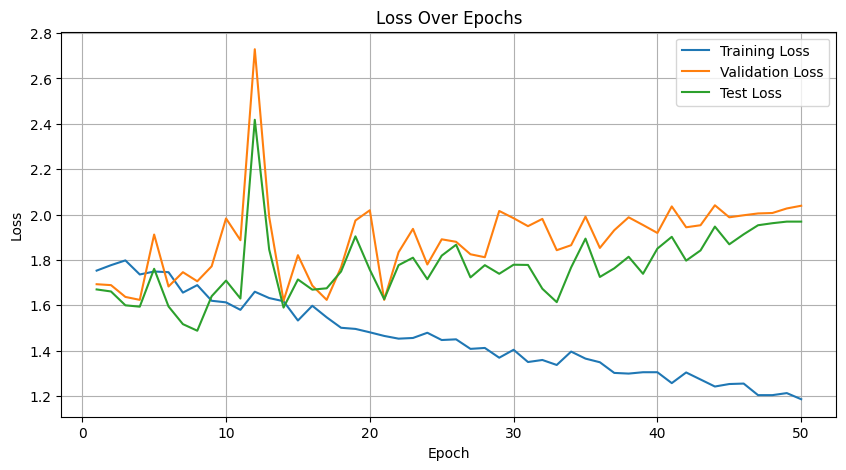

In [ ]:
log_data = extract_training_metrics("./logs/save_finetune_WS24.log")

# Separate the data by type
train_data = [entry for entry in log_data if entry['type'] == 'train']
valid_data = [entry for entry in log_data if entry['type'] == 'valid']
test_data = [entry for entry in log_data if entry['type'] == 'test']

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot([entry['epoch'] for entry in train_data], [entry['loss'] for entry in train_data], label='Training Loss')
plt.plot([entry['epoch'] for entry in valid_data], [entry['loss'] for entry in valid_data], label='Validation Loss')
plt.plot([entry['epoch'] for entry in test_data], [entry['loss'] for entry in test_data], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()